### <font color='darkred'>Análise Estatística Para Data Science com Linguagem Python</font>

### <font color='darkblue'>Análise Estatística de Séries Temporais</font>

### <font color='darkgreen'>Lab 1 - Parte 3 - AST - Estacionaridade - Tratamentos </font>


### <font color=darkred> <b>Instalando e Carregando os Pacotes </b> </font>

In [1]:
#Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
# !pip install -q -U watermark

In [3]:
# Imports para manipulação de dados
import numpy as np
import pandas as pd

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para análise de dados (parte1-Transformação) 
import scipy
from scipy.stats import boxcox

# Imports para análise de dados (parte2-Suavização)
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Michelle Bouhid" --iversions

Author: Michelle Bouhid

pandas     : 1.5.3
statsmodels: 0.13.2
matplotlib : 3.7.1
seaborn    : 0.11.2
scipy      : 1.9.1
numpy      : 1.22.4



### <font color=darkred> <b>Carregando o Conjunto de Dados </b> </font>

In [5]:
# Carrega os dados
# Observe que estamos carregando os dados e já definindo a data como índice com o parâmetro index_col = 0
dados = pd.read_csv('dados/dataset.csv', 
                    header = None, 
                    index_col = 0,
                    names = ['veiculos_produzidos'])

In [6]:
# Série
dados.head()

,veiculos_produzidos
2012-01,113
2012-02,119
2012-03,134
2012-04,129
2012-05,121


In [7]:
# Formatando as saídas dos gráficos
plt.style.use('fivethirtyeight')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

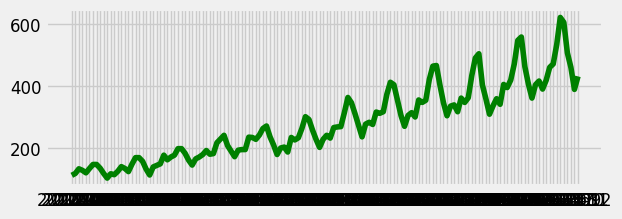

In [8]:
# Área de plotagem
plt.figure(1)

# Gráfico de Linha
plt.subplot(211)
plt.plot(dados['veiculos_produzidos'], color = "green")

(array([24., 27., 19., 18., 22., 13., 10.,  6.,  3.,  2.]),
 array([104. , 155.8, 207.6, 259.4, 311.2, 363. , 414.8, 466.6, 518.4,
        570.2, 622. ]),
 <BarContainer object of 10 artists>)

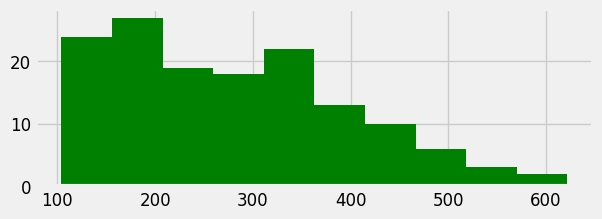

In [9]:
# Histograma
plt.subplot(211)
plt.hist(dados['veiculos_produzidos'], color = "green")

In [10]:
# Média da série
dados['veiculos_produzidos'].mean()

280.34027777777777

In [11]:
# Desvio Padrão da série
dados['veiculos_produzidos'].std()

119.91728869764206

O conjunto de dados é **não estacionário**, o que significa que a **média e a variância das observações mudam ao longo do tempo**. Isso dificulta a modelagem por métodos estatísticos clássicos, como ARIMA, e métodos mais sofisticados de aprendizado de máquina, como redes neurais.

A não estacionaridade é causada pelo que parece ser uma **tendência crescente e um componente de sazonalidade.**

Além disso, a quantidade de alteração ou a variância está aumentando com o tempo. Isso fica claro quando você olha para o **tamanho do componente sazonal e percebe que a amplitude (de baixo para cima) está aumentando.**

Vamos fazer ciência e experimentar diferentes técnicas de transformação a fim de converter a série em estacionária.

## <font color=darkgreen> <b>Transformação de Log </b> </font>

Séries temporais podem ser linearizadas usando o logaritmo dos valores. Isso é chamado de transformação de log. 

As transformações de log são populares em dados de séries temporais, pois são **eficazes na remoção da variação exponencial.**

<font color=darkblue> <b> É importante observar que esta operação assume que os valores são positivos e diferentes de zero. É comum transformar observações adicionando uma constante fixa para garantir que todos os valores de entrada atendam a esse requisito. 
> **Por exemplo: serie_transformada_y = log(constante + x)</b> </font>**

In [12]:
# Vamos aplicar uma transformação de log usando np.log() e gravamos o resultado em uma nova coluna do nosso dataset
dados['veiculos_produzidos_log'] = np.log(dados['veiculos_produzidos'])
dados.head()

,veiculos_produzidos,veiculos_produzidos_log
2012-01,113,4.727388
2012-02,119,4.779123
2012-03,134,4.897840
2012-04,129,4.859812
2012-05,121,4.795791


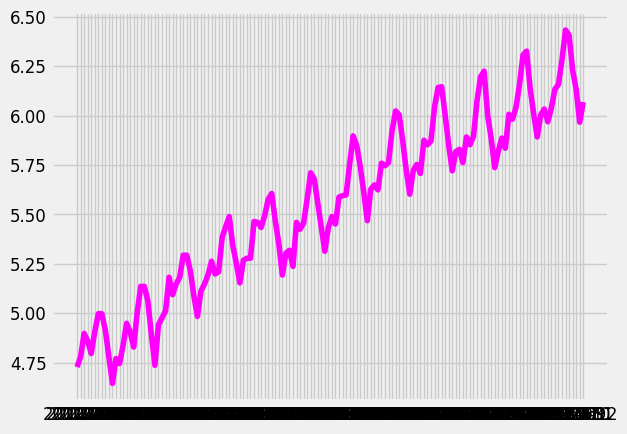

In [13]:
# Plot da série transformada
plt.plot(dados['veiculos_produzidos_log'], color = "magenta")

(array([ 8., 14., 11., 20., 16., 15., 27., 17., 11.,  5.]),
 array([4.6443909 , 4.82324582, 5.00210074, 5.18095566, 5.35981058,
        5.5386655 , 5.71752042, 5.89637533, 6.07523025, 6.25408517,
        6.43294009]),
 <BarContainer object of 10 artists>)

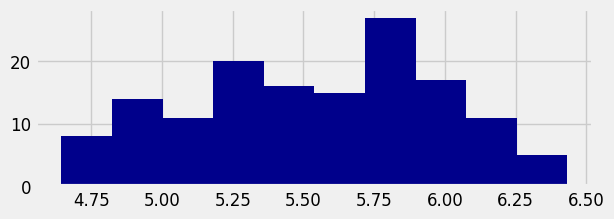

In [14]:
# Histograma da série transformada
plt.subplot(211)
plt.hist(dados['veiculos_produzidos_log'], color = "darkblue")

Análise:

-  A execução do exemplo resulta em uma tendência que parece mais linear. O gráfico de linha mostra um crescimento e variação aparentemente lineares.

- O histograma também mostra uma distribuição de observações do tipo gaussiana mais uniforme.

Vamos testar a estacionaridade.

In [15]:
# Função
def testa_estacionaridade(serie):
    
    from statsmodels.tsa.stattools import adfuller
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    
    # Plot
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

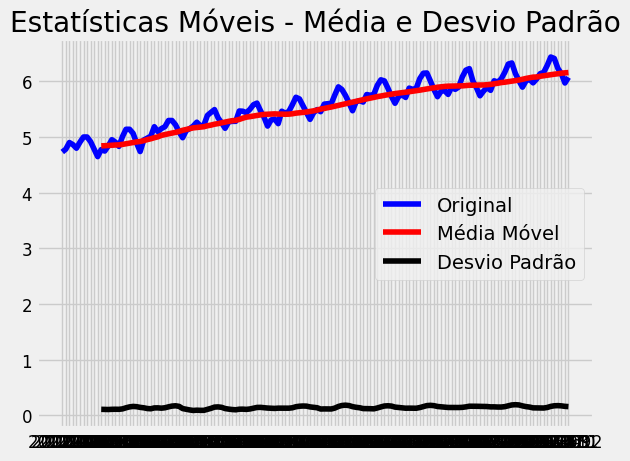


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -1.740668
Valor-p                           0.410290
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [16]:
# depois que roda a função, pode testar em todos os dataframes, nesse caso, os veiculos com tranformação de log
testa_estacionaridade(dados['veiculos_produzidos_log'])

Análise:

- A Transformação de Log não converteu a série em estacionária. Mas ok. Temos ainda outras técnicas a nossa disposição.

## <font color=darkgreen> <b>Transformação de Raiz Quadrada</b> </font>

Uma série temporal que tem uma tendência quadrática de crescimento pode ser linearizada calculando sua raiz quadrada.

É possível que nosso conjunto de dados mostre um crescimento quadrático. Se esse for o caso, poderíamos esperar que uma transformação de raiz quadrada, para reduzir a tendência de crescimento, seja linear e alterar a distribuição de observações para talvez ser quase gaussiana.

O exemplo abaixo executa uma raiz quadrada do conjunto de dados e plota os resultados.

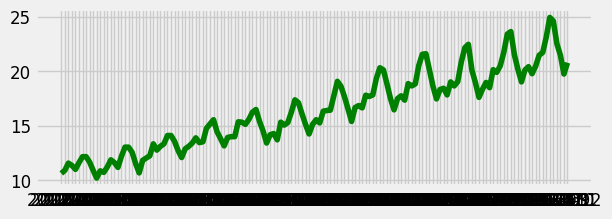

In [17]:
# Transformação de Raiz Quadrada com np.sqrt()
dados_sqrt = np.sqrt(dados['veiculos_produzidos'])

# Gráfico de Linha
plt.subplot(211)
plt.plot(dados_sqrt, color = "green")

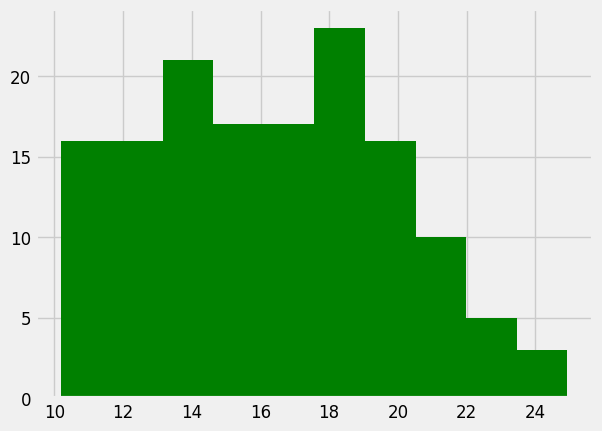

In [18]:
# Histograma
plt.hist(dados_sqrt, color = "green")
plt.show()

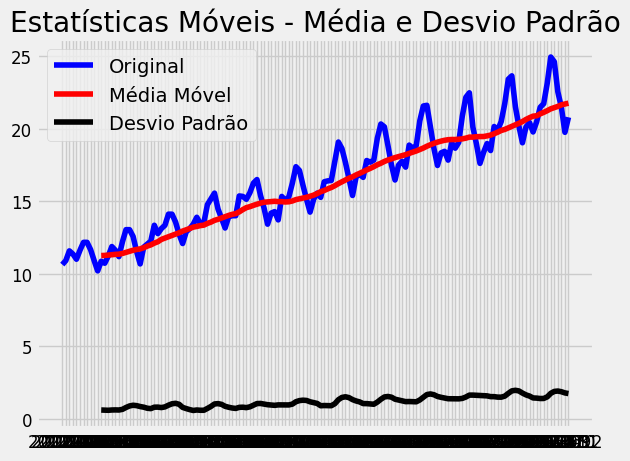


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -0.363637
Valor-p                           0.915995
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [19]:
# esse teste usa a função de teste que rodamos acima, agora testando com veiculos procuzidos ao quadrado.
testa_estacionaridade(dados_sqrt)

**Análise:**

- Podemos ver que a tendência foi reduzida, mas não foi removida.

- O gráfico de linha ainda mostra uma variação crescente de ciclo para ciclo. 
E o histograma ainda mostra uma cauda longa à direita da distribuição, sugerindo uma distribuição exponencial ou de cauda longa.


## <font color=darkgreen> <b>Transformação Box-Cox</b> </font>

A transformação de raiz quadrada e a transformação de log pertencem a uma classe de transformações denominadas **transformações de potência.**

A transformação Box-Cox é um método de transformação de dados configurável que suporta a raiz quadrada e a transformação de log, bem como um conjunto de transformações relacionadas.

Mais do que isso, pode ser configurado para avaliar um conjunto de transformações automaticamente e selecionar o melhor ajuste. A série resultante pode ser mais linear e a distribuição resultante mais gaussiana ou uniforme, dependendo do processo que a gerou.

A biblioteca scipy.stats fornece uma implementação da transformação Box-Cox. **A função boxcox() usa um argumento, chamado lambda, que controla o tipo de transformação a ser executada.**

Abaixo estão alguns valores comuns para lambda (usado como parâmetro aqui)
Nesse caso palica a fç e pode influenciar o resultado ajustando o parâmetro lambda

- lambda = -1. é uma transformação recíproca.
- lambda = -0,5 é uma transformação de raiz quadrada recíproca.
- lambda = 0,0 é uma transformação de log.
- lambda = 0,5 é uma transformação de raiz quadrada.
- lambda = 1.0 não é transformação.
Vamos ao exemplo:

In [20]:
# Aplicando Transformação Box-Cox
# Lambda = 0 é o mesmo que o log ou sqrt
dados['veiculos_produzidos_box'] = boxcox(dados['veiculos_produzidos'], lmbda = 0.0)
dados.head()

,veiculos_produzidos,veiculos_produzidos_log,veiculos_produzidos_box
2012-01,113,4.727388,4.727388
2012-02,119,4.779123,4.779123
2012-03,134,4.897840,4.897840
2012-04,129,4.859812,4.859812
2012-05,121,4.795791,4.795791


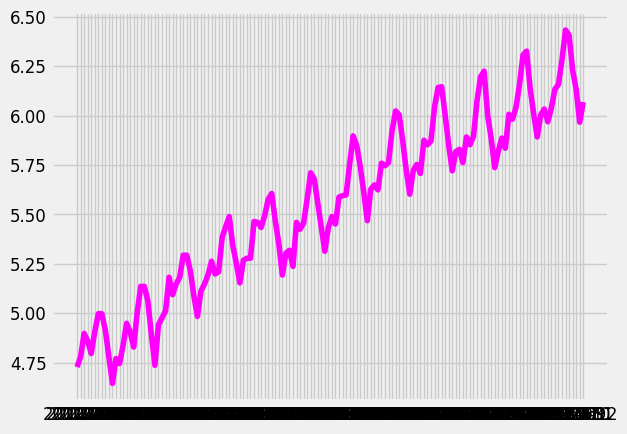

In [21]:
# Plot da série transformada
plt.plot(dados['veiculos_produzidos_box'], color = "magenta")

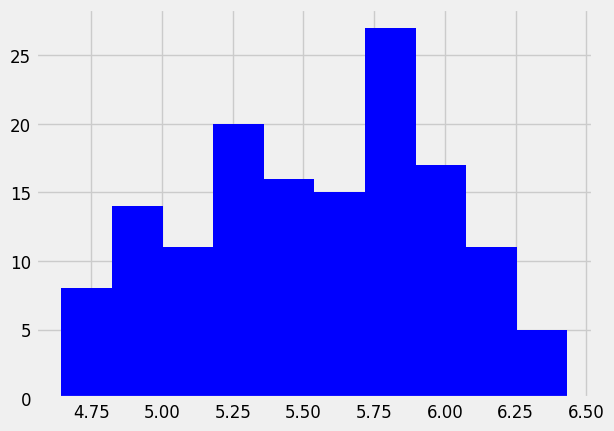

In [22]:
# Histograma
plt.hist(dados['veiculos_produzidos_box'], color = "blue")
plt.show()

Podemos definir o **parâmetro lambda como None (o padrão) e deixar a função encontrar um valor ajustado estatisticamente.**

O exemplo a seguir demonstra esse uso, retornando o conjunto de dados transformado e o valor lambda escolhido.

In [23]:
# Aplicando Transformação Box-Cox
# Box1 - lambda=0 e box2 - lambda foi o valor otimizado pela função 0,145516
dados['veiculos_produzidos_box_2'], lam_value = boxcox(dados['veiculos_produzidos'])
print('Valor Ideal de Lambda: %f' % lam_value)
dados.head()

Valor Ideal de Lambda: 0.145516


,veiculos_produzidos,veiculos_produzidos_log,veiculos_produzidos_box,veiculos_produzidos_box_2
2012-01,113,4.727388,4.727388,6.800303
2012-02,119,4.779123,4.779123,6.903622
2012-03,134,4.897840,4.897840,7.143666
2012-04,129,4.859812,4.859812,7.066323
2012-05,121,4.795791,4.795791,6.937073


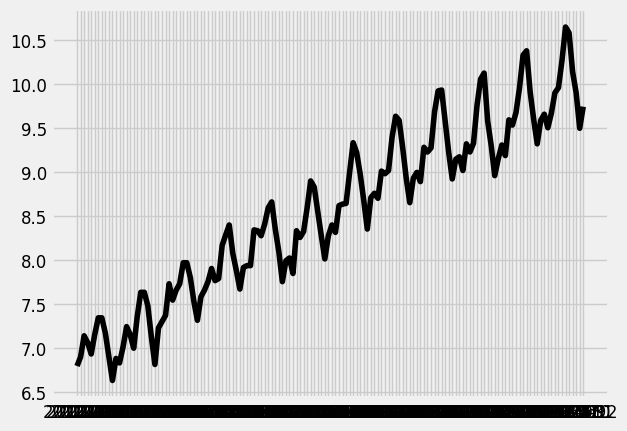

In [24]:
# Plot da série transformada
plt.plot(dados['veiculos_produzidos_box_2'], color = "black")

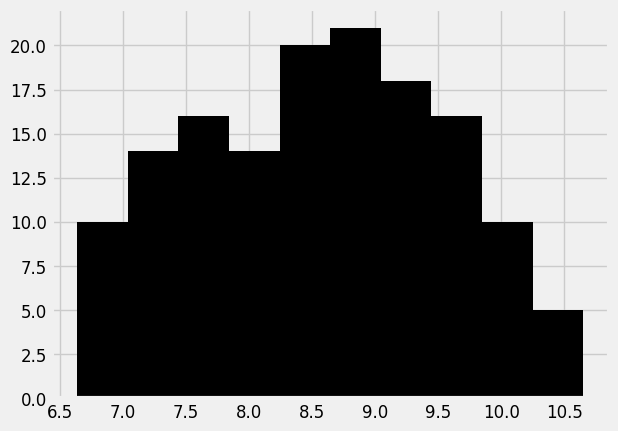

In [25]:
# Histograma
plt.hist(dados['veiculos_produzidos_box_2'], color = "black")
plt.show()

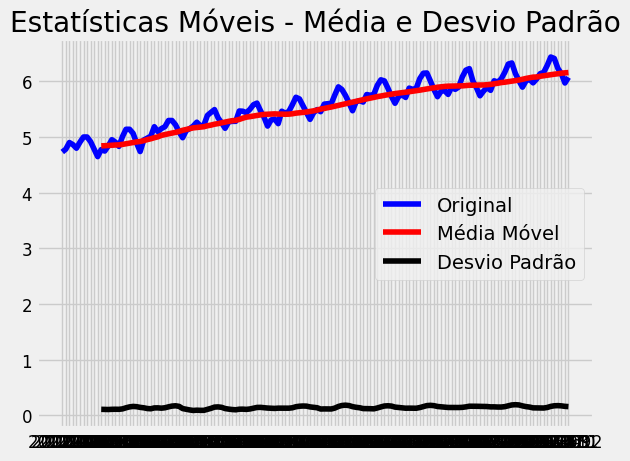


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -1.740668
Valor-p                           0.410290
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [26]:
testa_estacionaridade(dados['veiculos_produzidos_box'])

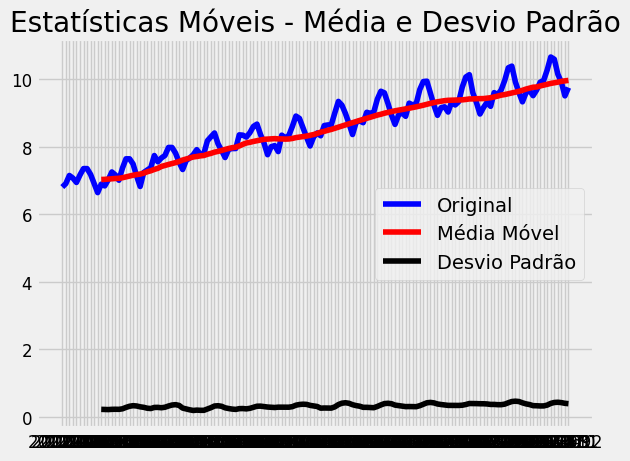


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -1.354872
Valor-p                           0.603710
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [27]:
testa_estacionaridade(dados['veiculos_produzidos_box_2'])

**Análise:**

- A execução do exemplo gerou o valor lambda de 0,148.

- Podemos ver que isso está muito próximo de um valor lambda de 0,0, resultando em uma transformação de log mais forte (e menor) que 0.5 para a transformação de raiz quadrada.

Aparentemente nenhuma das técnicas anteriores apresentou resultado para tornar nossa série estacionária. Mas temos ainda algumas cartas na manga, ou melhor, algumas outras técnicas. (log/raiz quadrada/boxcox)

### <font color=darkgreen> <b>Técnicas de TRANSFORMAÇÂO utilizadas até aqui:</b> </font>
    
**- Logaritmicas, raiz quadrada e boxcox**

In [28]:
dados.head()

,veiculos_produzidos,veiculos_produzidos_log,veiculos_produzidos_box,veiculos_produzidos_box_2
2012-01,113,4.727388,4.727388,6.800303
2012-02,119,4.779123,4.779123,6.903622
2012-03,134,4.897840,4.897840,7.143666
2012-04,129,4.859812,4.859812,7.066323
2012-05,121,4.795791,4.795791,6.937073


### <font color=darkblue> <b>Técnicas de SUAVIZAÇÃO que serão utilizadas a seguir: </b> </font>

**- Média Móvel Simples e Média Móvel Ponderada Exponencial**
    

In [29]:
# Carrega os dados novamente para ficar com apenas 1 coluna e poder fazer os calculos a seguir
# Observe que estamos carregando os dados e já definindo a data como índice com o parâmetro index_col = 0
dados_serie = pd.read_csv('dados/dataset.csv', 
                          header = None, 
                          index_col = 0,
                          names = ['veiculos_produzidos'])

In [30]:
# Série
dados_serie.head()

,veiculos_produzidos
2012-01,113
2012-02,119
2012-03,134
2012-04,129
2012-05,121


## <font color=darkgreen> <b>Suavização Através da Média Móvel Simples</b> </font>
- Calculamos a média de valores 'k' consecutivos, dependendo da frequência da série temporal.
- Aqui podemos calcular a média do último 1 ano, ou seja, os últimos 12 valores.
- Uma desvantagem dessa abordagem específica é que o período de tempo deve ser estritamente definido.

In [31]:
# Primeiro, vamos calcular a média da série (essa não é a média móvel, mas sim a média total)
# A media movel requer uma janela de frequência que passa pelos dados
dados_serie.mean()

veiculos_produzidos    280.340278
dtype: float64

In [32]:
# Vamos criar uma cópia da série original pois isso será importante mais tarde
df_serie = dados_serie.copy()

In [33]:
# Agora definimos uma janela de 12 meses da série temporal para calcular a média móvel
# Vamos gravar o resultado em outra coluna no próprio dataset
dados_serie['veiculos_produzidos_serie_suavizada'] = dados_serie.rolling(window = 12).mean()

In [34]:
# Imprime o dataset 
dados_serie

,veiculos_produzidos,veiculos_produzidos_serie_suavizada
2012-01,113,NaN
2012-02,119,NaN
2012-03,134,NaN
2012-04,129,NaN
2012-05,121,NaN
...,...,...
2023-08,606,463.333333
2023-09,508,467.083333
2023-10,461,471.583333
2023-11,390,473.916667


Agora temos duas colunas e alguns valores NaN na coluna das médias móveis. Isso é normal e esperado, afinal, calculamos a média de 12 valores consecutivos "deslizando" a janela pela série e para alguns valores (os primeiros da série) não teremos como calcular a média dos 12 valores anteriores e assim eles ficam como NaN. Ou seja, perdemos registros da série ao aplicar esta técnica de suavização.

In [35]:
# Perde 11 registros, porque ele só consegue calcular a media de 12 elementos qdo chega no 12º elemento, gerando valor ausente
# Primeiros 20 registros da série
dados_serie.head(20)

,veiculos_produzidos,veiculos_produzidos_serie_suavizada
2012-01,113,NaN
2012-02,119,NaN
2012-03,134,NaN
2012-04,129,NaN
2012-05,121,NaN
2012-06,135,NaN
2012-07,148,NaN
2012-08,148,NaN
2012-09,136,NaN
2012-10,119,NaN


In [36]:
# Últimos 20 registros da série
dados_serie.tail(20)

,veiculos_produzidos,veiculos_produzidos_serie_suavizada
2022-05,420,397.083333
2022-06,472,400.166667
2022-07,548,404.916667
2022-08,559,409.416667
2022-09,463,414.333333
2022-10,407,418.333333
2022-11,362,422.666667
2022-12,405,428.333333
2023-01,417,433.083333
2023-02,391,437.166667


Vamos plotar a série original e a série suavizada com a média móvel:

In [37]:
# Imports para formatação dos gráficos
from pylab import rcParams
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['text.color'] = 'k'
rcParams['figure.figsize'] = 18, 8
plt.style.use('fivethirtyeight')

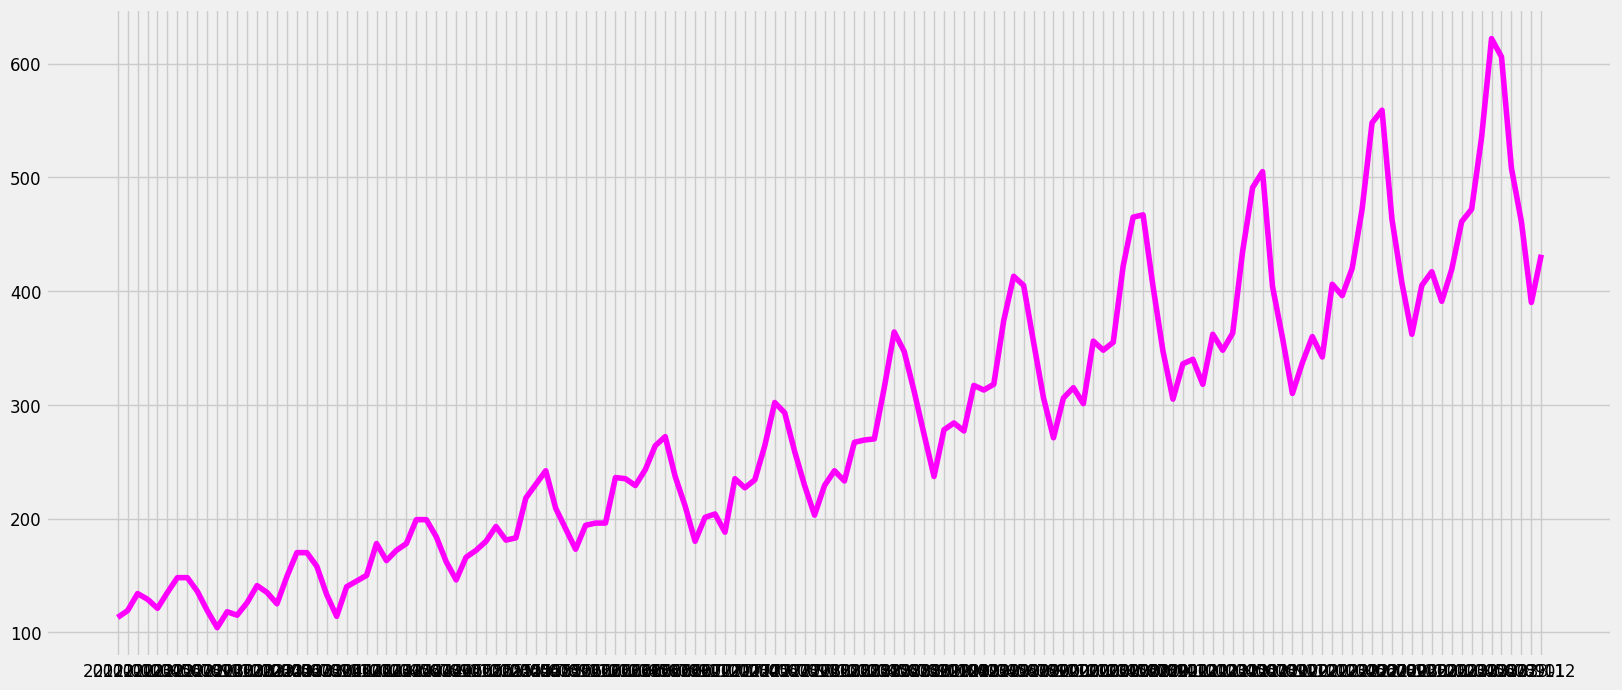

In [38]:
# Plot da série original
plt.plot(dados_serie['veiculos_produzidos'], color = 'magenta')

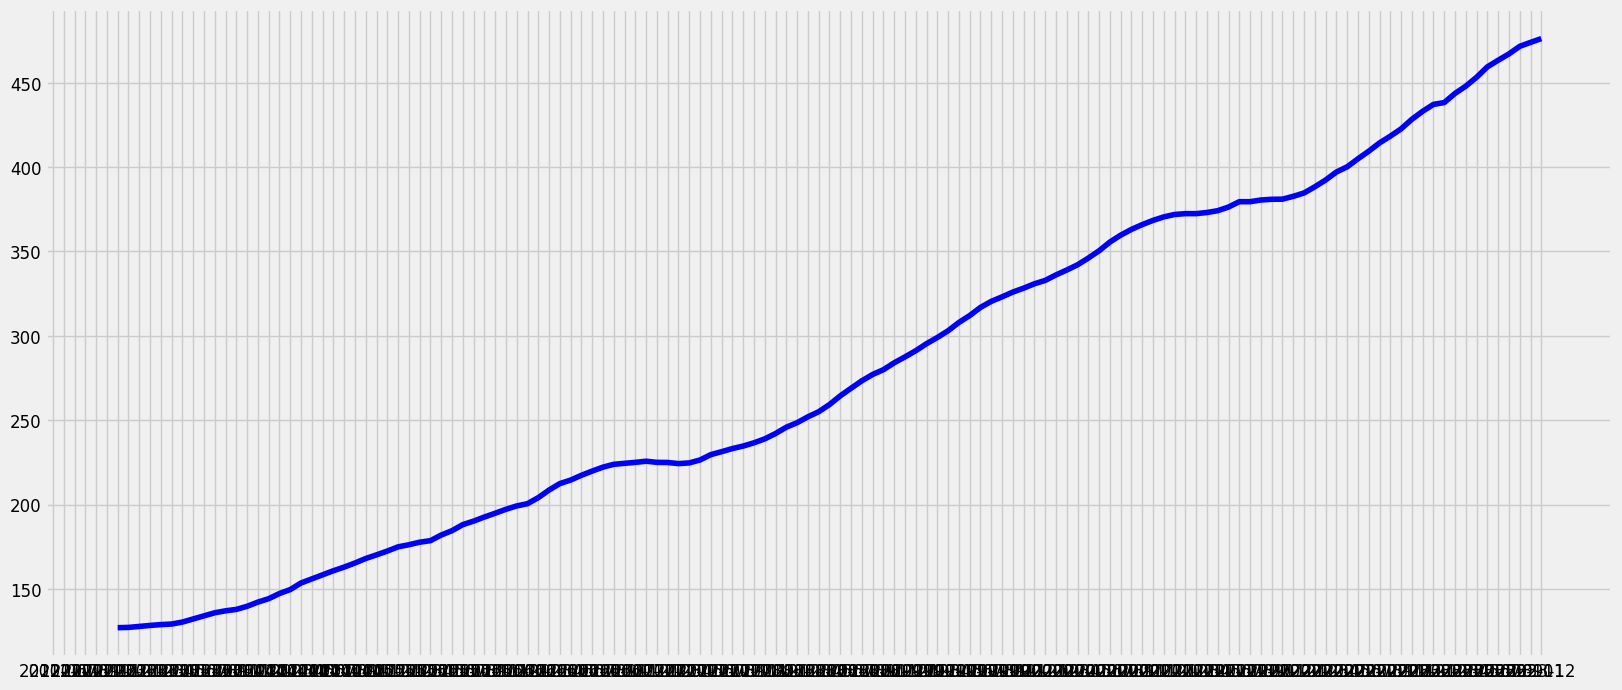

In [39]:
# Plot da série suavizada
plt.plot(dados_serie['veiculos_produzidos_serie_suavizada'], color = 'blue')

A diferença é grande, não é? Vamos colocar as duas juntas agora.

A linha azul calcula a média aolongo do tempo, desliza as janelas

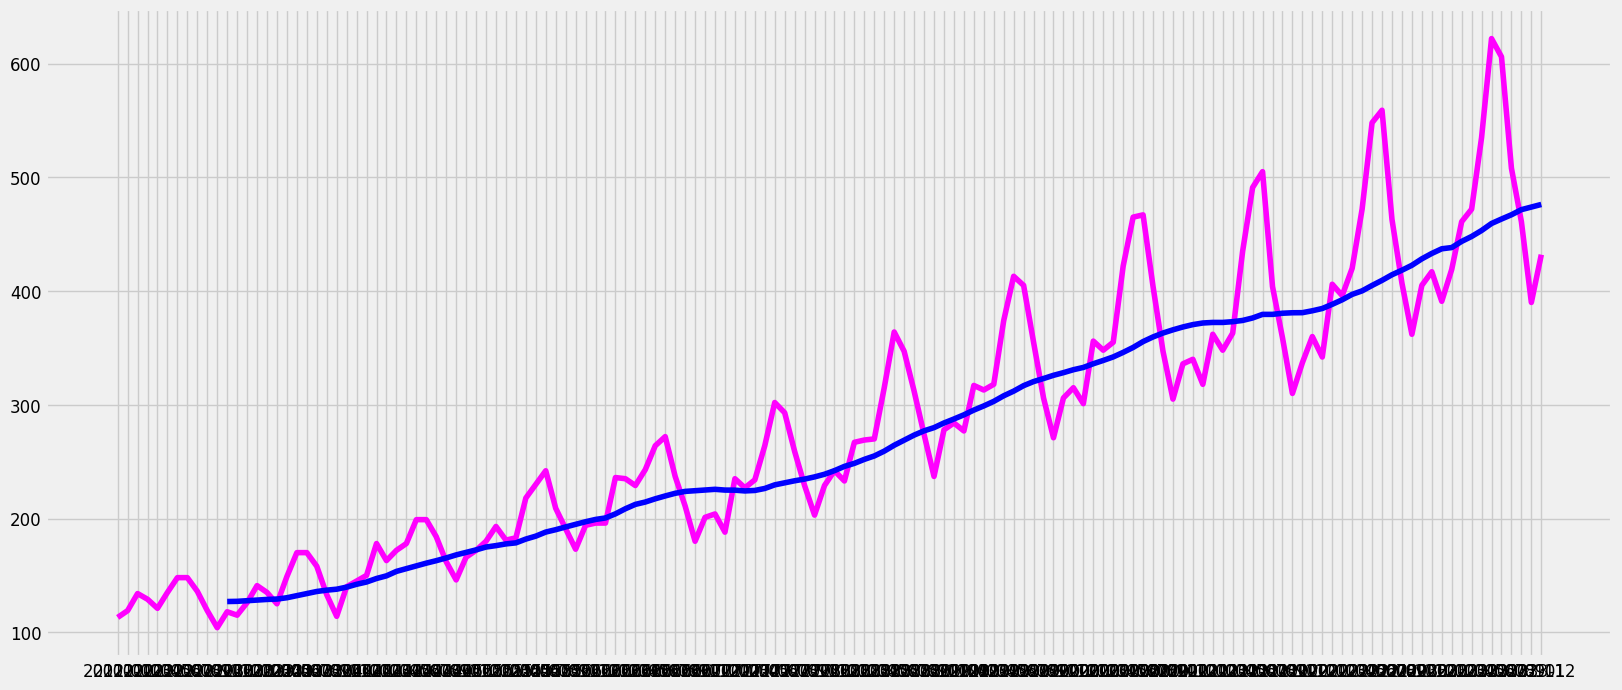

In [40]:
# Agora as duas juntas
plt.plot(dados_serie['veiculos_produzidos'], color = 'magenta')
plt.plot(dados_serie['veiculos_produzidos_serie_suavizada'], color = 'blue')

In [41]:
# Calculando a diferença entre a série original e a série suavizada
# Aqui estamos removendo a tendência da série original e deixando apenas a sazonalidade
diff_original_suavizada = dados_serie['veiculos_produzidos'] - dados_serie['veiculos_produzidos_serie_suavizada']
diff_original_suavizada.head(20)

2012-01          NaN
2012-02          NaN
2012-03          NaN
2012-04          NaN
2012-05          NaN
2012-06          NaN
2012-07          NaN
2012-08          NaN
2012-09          NaN
2012-10          NaN
2012-11          NaN
2012-12    -9.000000
2013-01   -12.166667
2013-02    -1.750000
2013-03    12.666667
2013-04     6.166667
2013-05    -4.166667
2013-06    18.666667
2013-07    37.833333
2013-08    36.000000
dtype: float64

In [42]:
# Vamos remover os valores NA para testar a estacionaridade
diff_original_suavizada.dropna(inplace = True)

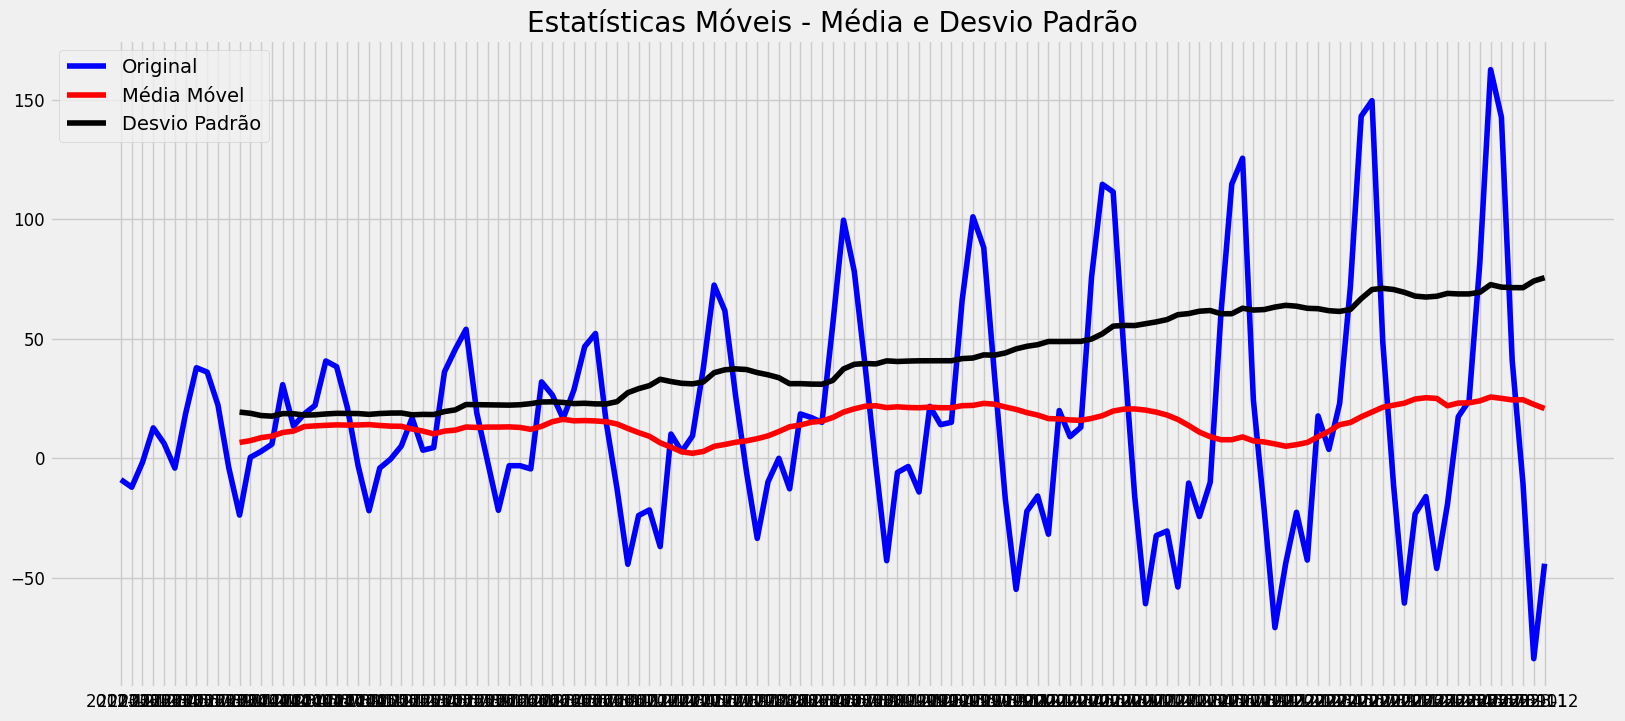


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -3.155236
Valor-p                           0.022726
Número de Lags Consideradas      13.000000
Número de Observações Usadas    119.000000
Valor Crítico (1%)               -3.486535
Valor Crítico (5%)               -2.886151
Valor Crítico (10%)              -2.579896
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [43]:
# Executando o teste de estacionaridade
# Usando a funçao ´presente´lá da parte 1 de trasnformação
testa_estacionaridade(diff_original_suavizada)

**Aplicamos a suavização e extraímos a tendência da série.** Esta série foi transformada e já poderíamos usá-la para modelagem estatística. Mas temos um problema. Perdemos uma parte dos dados, parte essa que poderia ser importante para prever o comportamento futuro.

**Vamos testar outra técnica de suavização e verificar se temos sucesso sem perder tantos dados.**

## <font color=darkgreen> <b>Suavização Através da Média Móvel Ponderada Exponencial</b> </font>

- Para superar o problema de escolher uma janela definida na média móvel, podemos usar a média móvel ponderada exponencial.
- Adotamos uma "média móvel ponderada", em que valores mais recentes recebem um peso maior.
- Pode haver muitas técnicas para atribuir pesos. Uma popular é a média móvel ponderada exponencialmente em que os pesos são atribuídos a todos os valores anteriores com um fator de redução.

A função ewm() do Pandas permite aplicar esse método com facilidade.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

In [44]:
# Aplicando suavização exponencial
# Observe que estamos aplicando a suavização à série original (antes de aplicar a suavização anterior)
serie_suavizada_exp = df_serie.ewm(alpha = 0.2, adjust = True).mean()

In [45]:
serie_suavizada_exp

,veiculos_produzidos
2012-01,113.000000
2012-02,116.333333
2012-03,123.573770
2012-04,125.411924
2012-05,124.099476
...,...
2023-08,512.214093
2023-09,511.371274
2023-10,501.297019
2023-11,479.037615


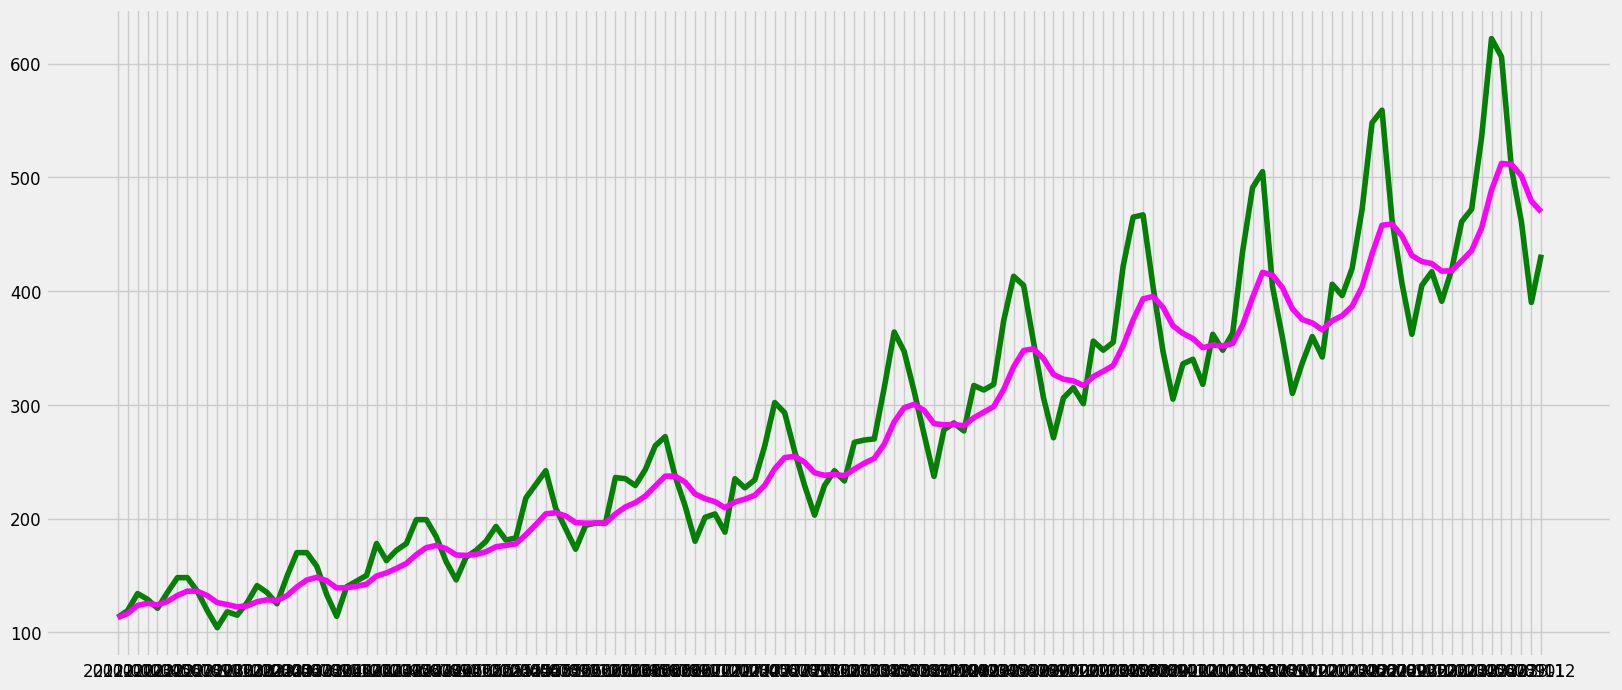

In [46]:
# Plt das séries
plt.plot(df_serie, color = 'green')
plt.plot(serie_suavizada_exp, color = 'magenta')

Suavização aplicada. Vamos agora calcular a diferença e aplicar o teste de estacionaridade.

In [47]:
# Diferença
diff_original_suav_exp = df_serie.veiculos_produzidos - serie_suavizada_exp.veiculos_produzidos

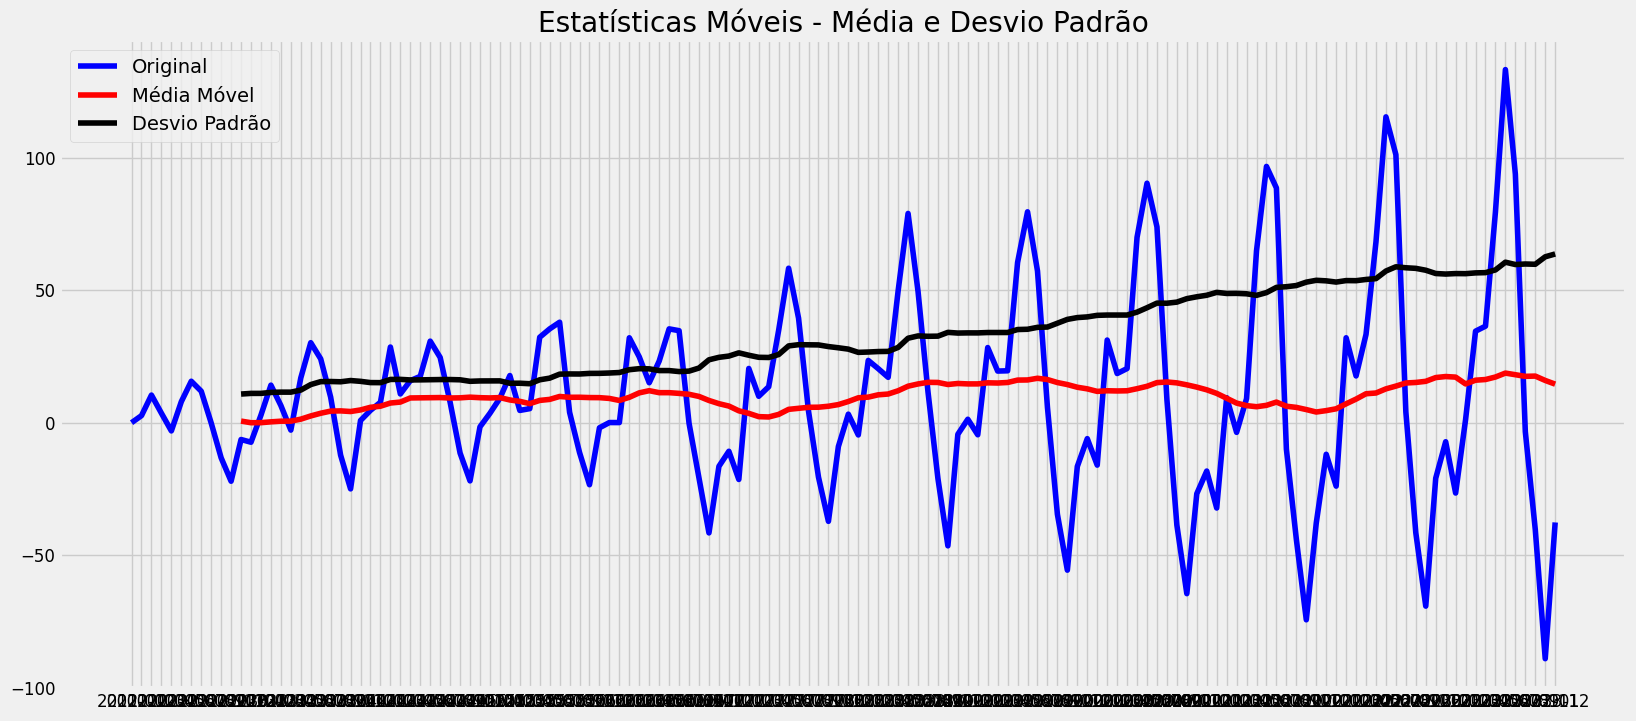


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -2.820660
Valor-p                           0.055383
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [48]:
# Executando o teste de estacionaridade
testa_estacionaridade(diff_original_suav_exp)

Perceba que a Suavização Exponencial não foi suficiente para deixar a série estacionária.

**Com a suavização podemos transformar nossa série em estacionária, apesar de perdermos dados com o calculo da media movel. 
Como essas técnicas simples de suavização não funcionam em todos os casos, principalmente nos de alta sazonalidade, vamos continuar experimentando e testar a tecnica de diferenciação.**

## <font color=darkred> <b> Aplicando DIFERENCIAÇÃO </b> </font>


In [49]:
# Carrega os dados
# Observe que estamos carregando os dados e já definindo a data como índice com o parâmetro index_col = 0
dados_serie = pd.read_csv('dados/dataset.csv', 
                          header = None, 
                          index_col = 0,
                          names = ['veiculos_produzidos'])

In [50]:
# Série
dados_serie.head()

,veiculos_produzidos
2012-01,113
2012-02,119
2012-03,134
2012-04,129
2012-05,121


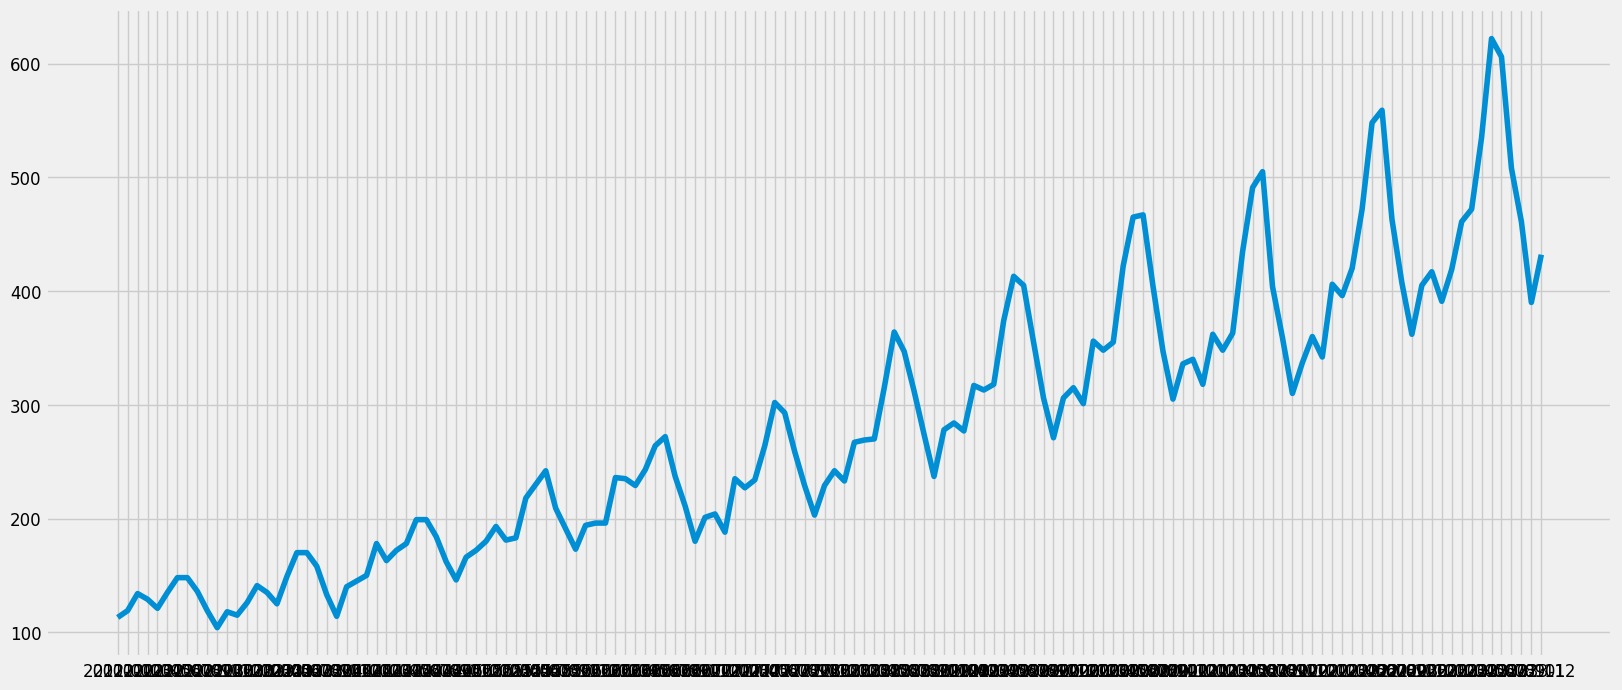

In [51]:
# Imports para formatação dos graficos foram feitos anteriormente
# Plot
plt.plot(dados_serie)

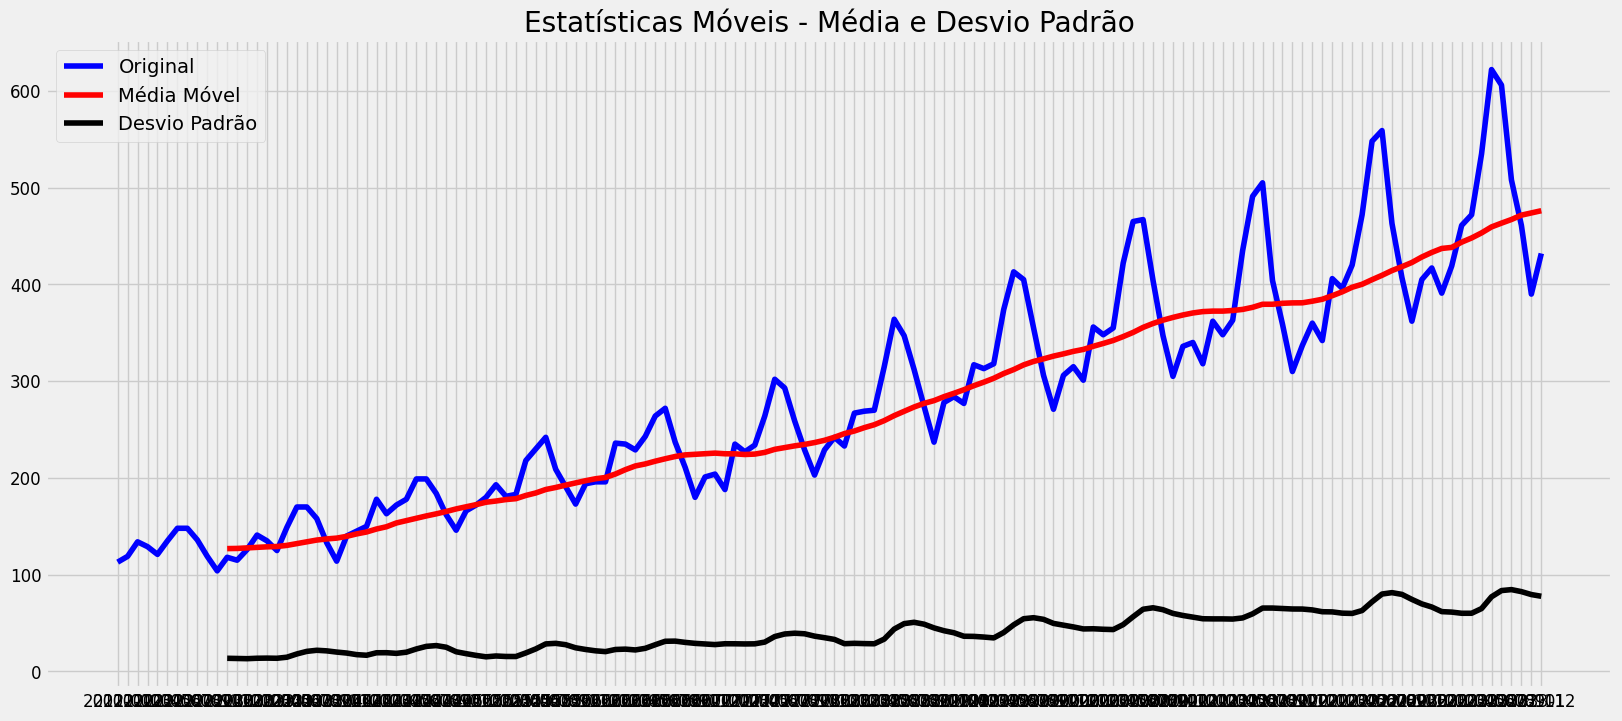


Resultado do Teste Dickey-Fuller:

Estatística do Teste              0.804910
Valor-p                           0.991715
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [52]:
# Utilizamos a Função 'presente' para automatizar o teste de estacionaridade, rodada acima
# Vamos testar a estacionaridade da série antes de qualquer transformação
testa_estacionaridade(dados_serie)

A série claramente não é estacionária. Média e variância (nesse caso desvio padrão, que é raiz quadrada da variância) variam ao longo do tempo. 

**Vamos aplicar técnicas de diferenciação e tentar estacionarizar a série.**


### <font color=darkred> <b> Aplicando DIFERENCIAÇÃO para remover TENDÊNCIA </b> </font>

**Primeiro precisamos colocar os dados na mesma escala com a transformação de log e em seguida aplicar a diferenciação.**

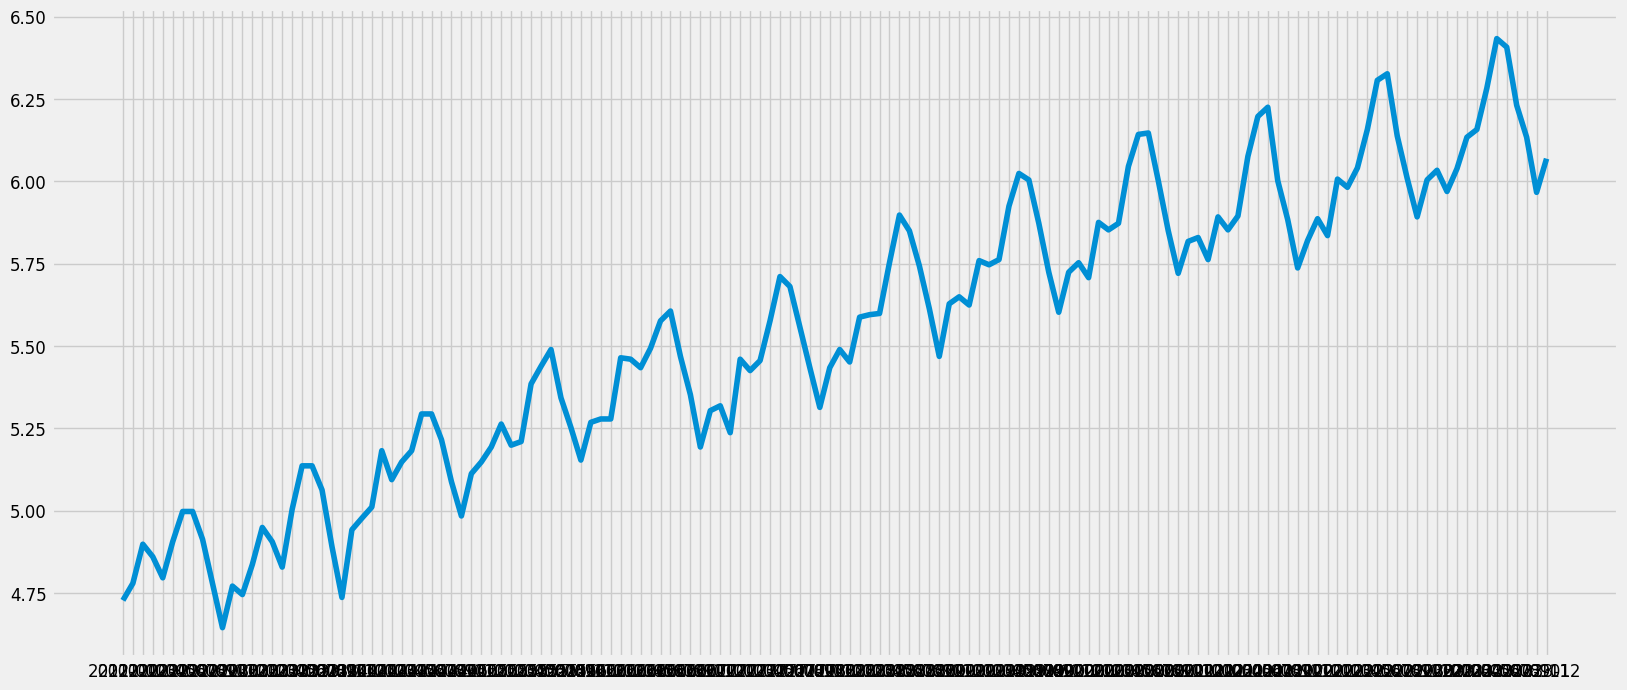

In [53]:
# Transformação de log para deixar os dados na mesma escala
dados_serie_log = np.log(dados_serie)
plt.plot(dados_serie_log)

In [54]:
dados_serie.head() 

,veiculos_produzidos
2012-01,113
2012-02,119
2012-03,134
2012-04,129
2012-05,121


In [55]:
dados_serie_log.head()

,veiculos_produzidos
2012-01,4.727388
2012-02,4.779123
2012-03,4.897840
2012-04,4.859812
2012-05,4.795791


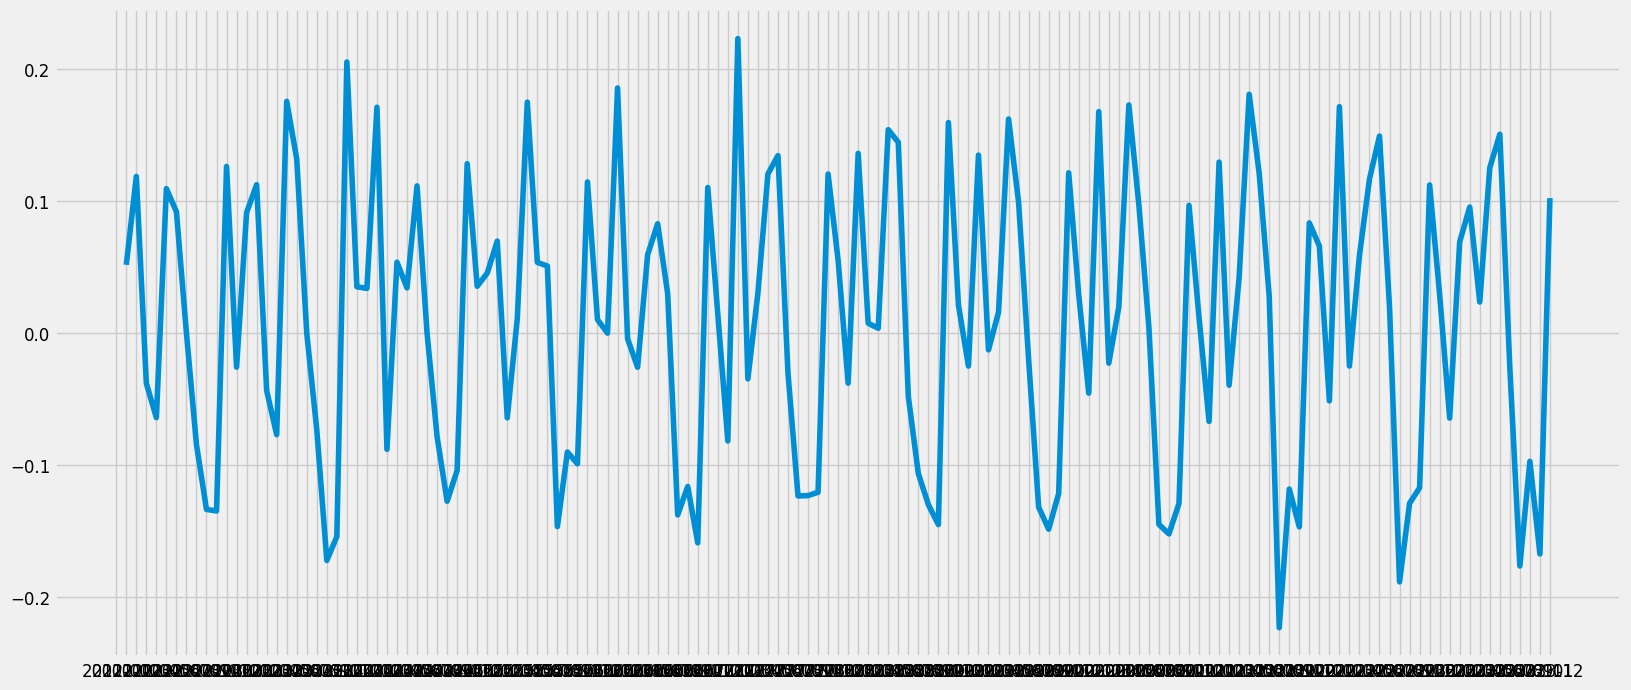

In [56]:
# Diferenciação Para Remover Tendência - Exemplo 1
# O método shift() move os dados em uma unidade do Pandas
# Estamos movendo os dados em 1 posição para fazer a subtração. Pode mudar o shift passando parametro entre parenteses
# Observe que estamos usando a série com transformação de log já aplicada
dados_serie_diff1 = dados_serie_log.veiculos_produzidos - dados_serie_log.veiculos_produzidos.shift()
plt.plot(dados_serie_diff1)

In [57]:
# Você pode criar sua função para diferenciação, se desejar:
# entendendo o shift
# Criando lista vazia
def diffFunc(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval] #shift = i-interval
        diff.append(value)
    return diff

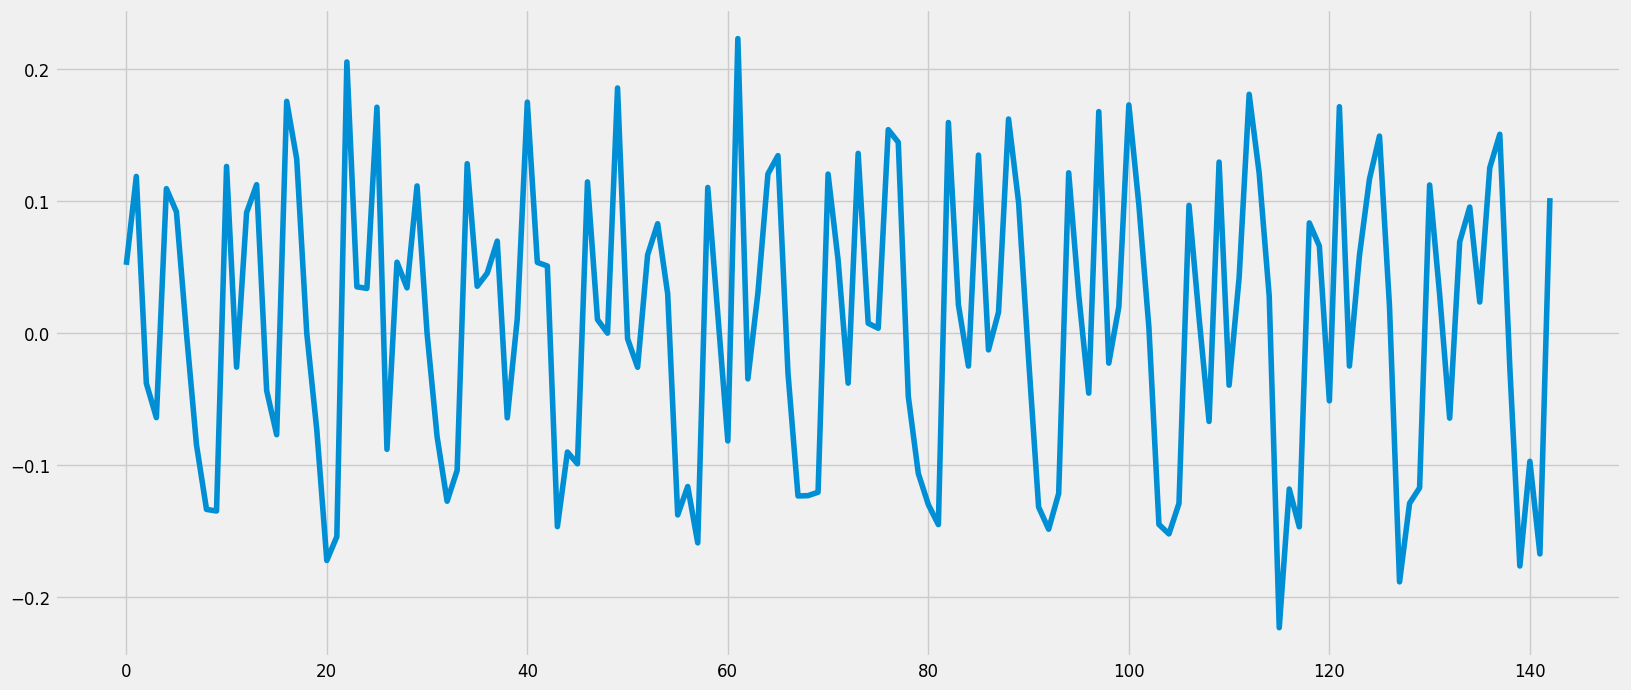

In [58]:
# Diferenciação Para Remover Tendência - Exemplo 2
# Observe que estamos usando a série com transformação de log
dados_serie_diff2 = diffFunc(dados_serie_log['veiculos_produzidos'])
plt.plot(dados_serie_diff2)

In [59]:
# Converte em dataframe, a lista gerada ao aplicar a diferenciação
dados_serie_diff2_df = pd.DataFrame(dados_serie_diff2) 

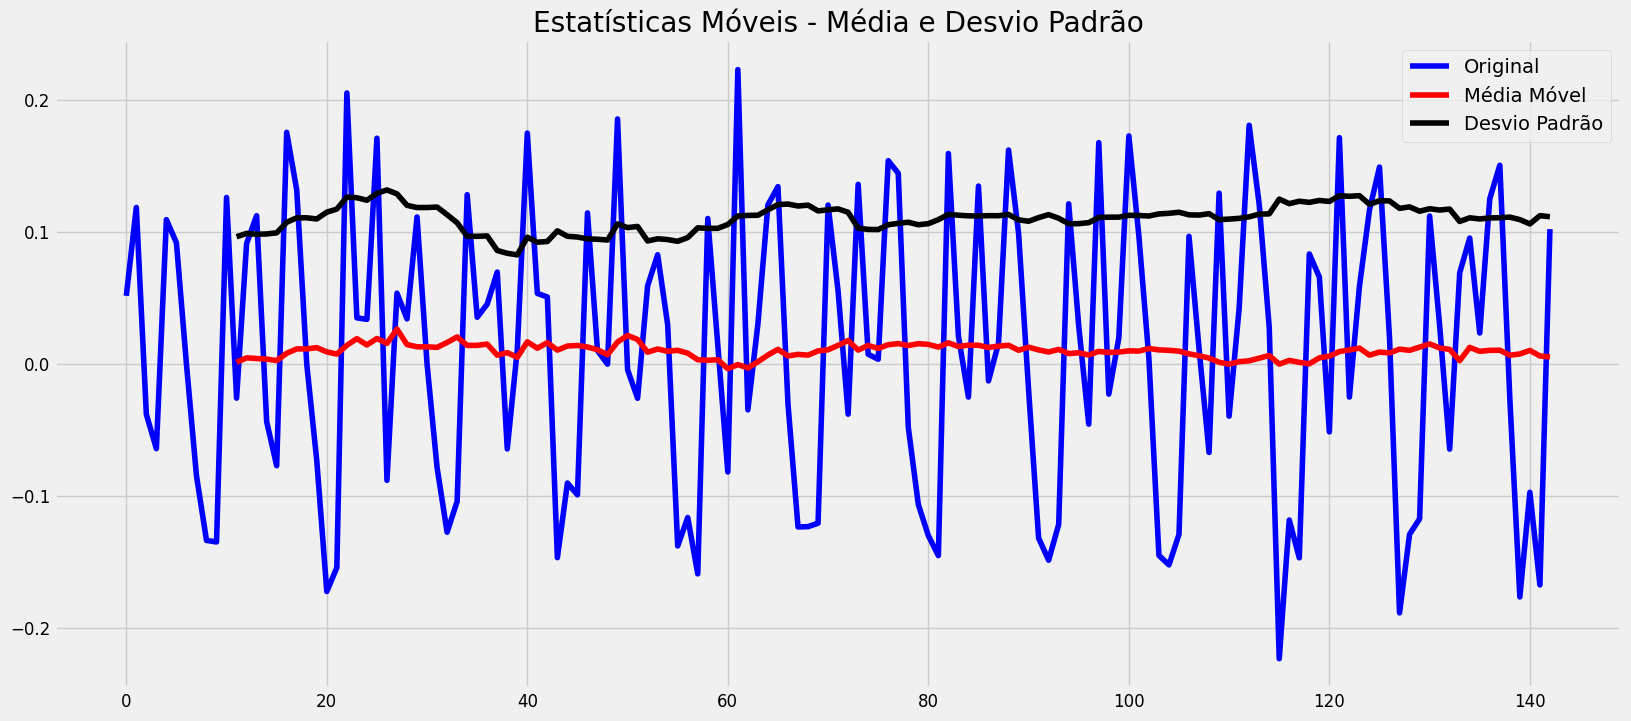


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -2.743996
Valor-p                           0.066729
Número de Lags Consideradas      14.000000
Número de Observações Usadas    128.000000
Valor Crítico (1%)               -3.482501
Valor Crítico (5%)               -2.884398
Valor Crítico (10%)              -2.578960
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [60]:
# Vamos testar a estacionaridade da série após a diferenciação para remover a tendência
# Como os 2 exemplos anteriores geram o mesmo resultado, vamos usar o segundo
testa_estacionaridade(dados_serie_diff2_df)

O valor-p reduziu bastante e está quase próximo do limite e média e variância estão quase constantes. Talvez remover somente a tendência ou somente a sazonalidade não seja suficiente. Vamos então tentar remover ambos. 

### <font color=darkred> <b> Aplicando DIFERENCIAÇÃO para remover SAZONALIDADE</b> </font>

**O exemplo abaixo aplica a função diffFunc() à última versão da nossa série até aqui, com transformacão de log e diferenciação para remover tendência. Ou seja, aplicamos duas rodadas de diferenciação.**

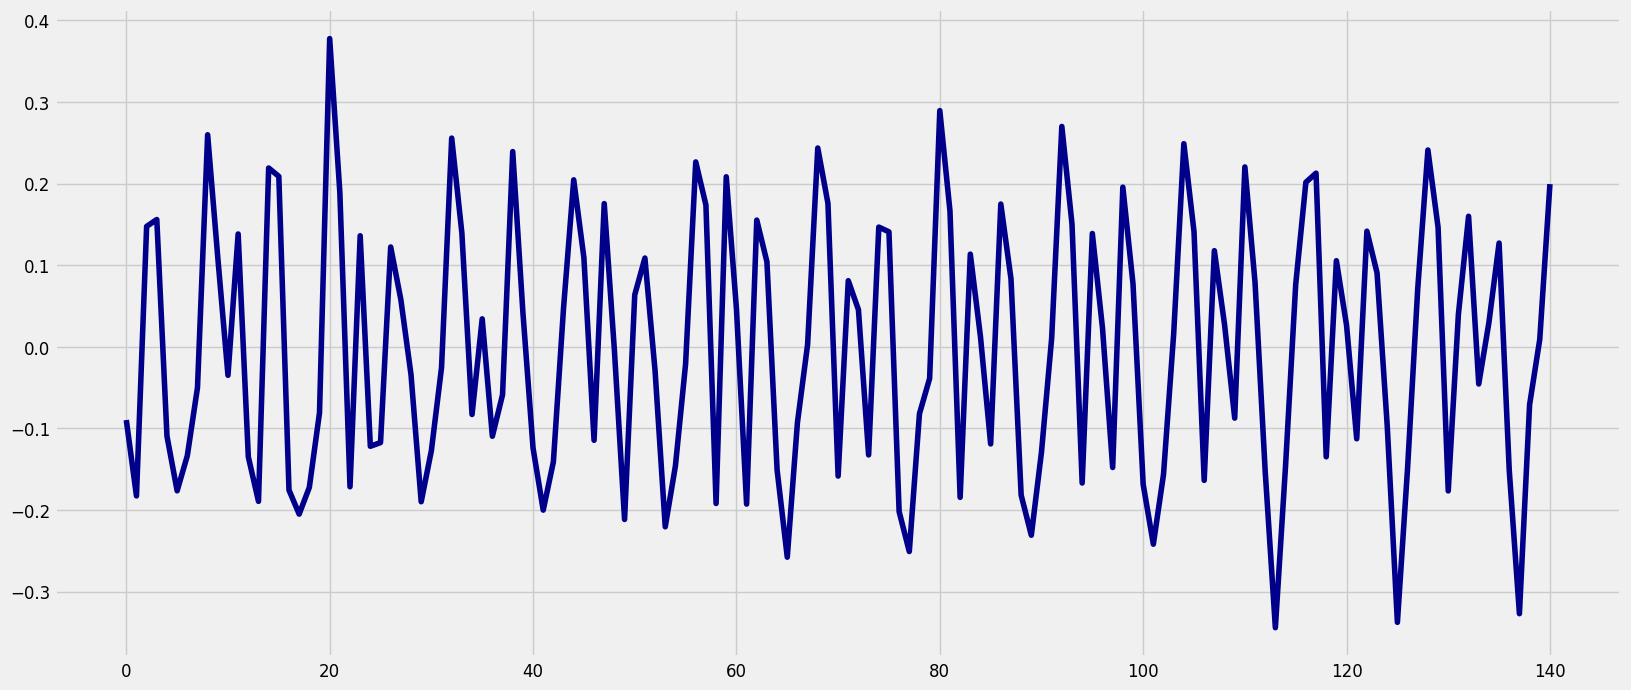

In [61]:
# Diferenciação para remover sazonalidade
# Observe o valor 2. Representa o intervalo para calcular a diferenciação. 
# Colocamos o valor 2 apenas para mostrar que é possível, mas se usarmos o valor 1 como usamos na 
# primeira diferenciação, o resultado é tão bom quanto.
# Faz o shift 2 vezes
dados_serie_diff3 = diffFunc(dados_serie_diff2, 2)
plt.plot(dados_serie_diff3 , color = 'darkblue')

In [62]:
# Converte em dataframe a lista gerada ao aplicar a diferenciação
# Tem que ser datafreme do pandas para usar o teste "presente"
dados_serie_final = pd.DataFrame(dados_serie_diff3) 

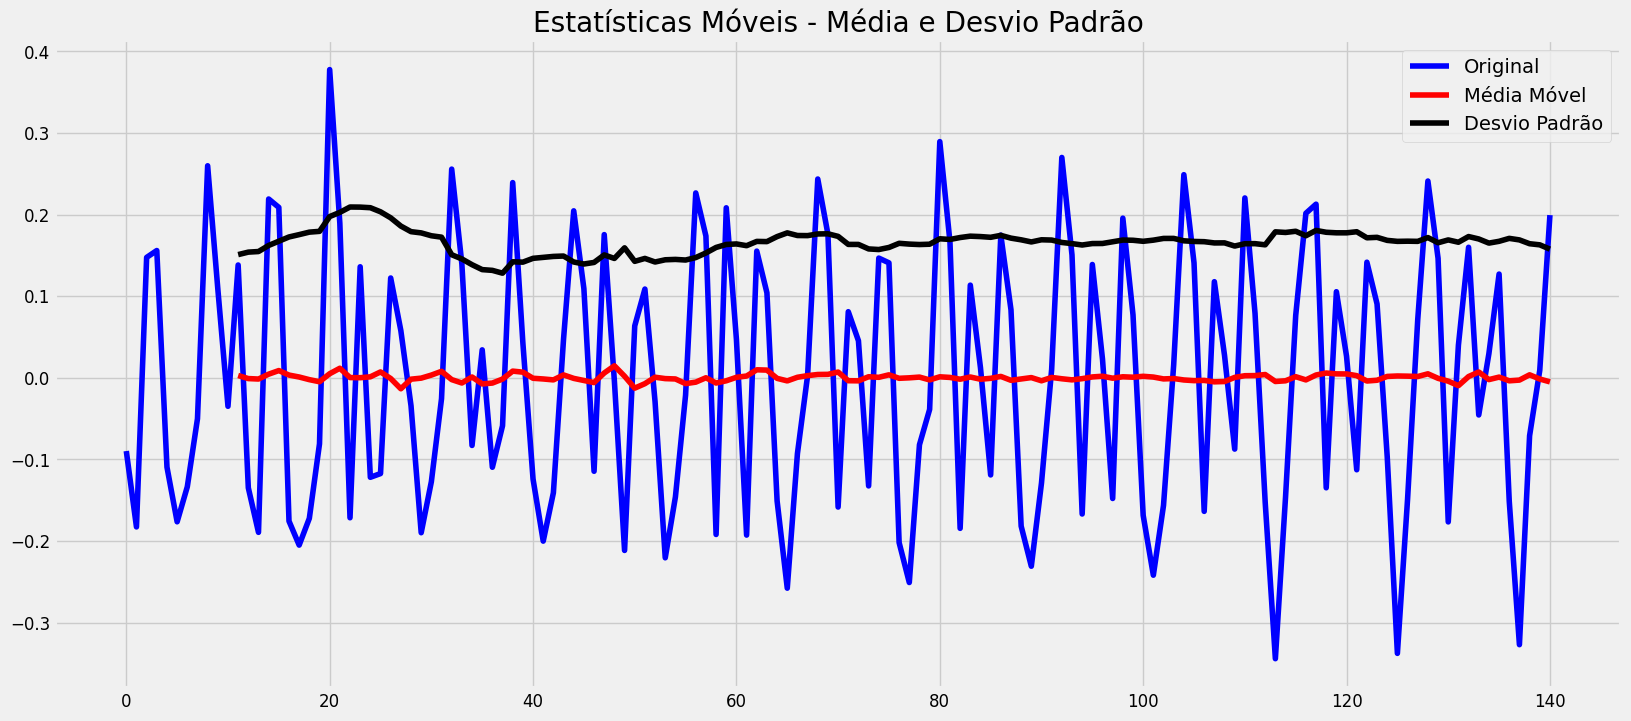


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -1.487532e+01
Valor-p                         1.639884e-27
Número de Lags Consideradas     1.000000e+01
Número de Observações Usadas    1.300000e+02
Valor Crítico (1%)             -3.481682e+00
Valor Crítico (5%)             -2.884042e+00
Valor Crítico (10%)            -2.578770e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [63]:
# Testa a estacionaridade
testa_estacionaridade(dados_serie_final)

Ufa! Deu trabalho. Mas aí está. Nossa série agora é estacionária e conseguimos isso sem perder dados. 

Podemos usá-la para construir modelos preditivos. 
Observe que as estatísticas agora são constantes e não variam mais com o tempo.

Ou seja, transformamos os dados, mas sem perder a informação, a fim de observar a tendência da série por outro ângulo e 
agora poder realizar previsões verdadeiramente válidas e profissionais. Se usássemos a série no formato original, 
faríamos previsões incorretas. 

Cada uma das técnicas mostradas aqui tem pontos positivos e negativos e serão mais ou menos eficientes dependendo dos dados.

Vamos construir nossos modelos preditivos e prever o número de veiculos produzidos no próximo capítulo.

Um framework avançado para a **manipulação de séries temporais regulares** pode ser composto por diversos componentes-chave para manipulação, análise e previsão. Aqui está um exemplo de um framework que poderia ser utilizado:

- Ingestão de Dados: Este componente é responsável por adquirir e importar os dados da série  temporal.  Isso  poderia  incluir  funções  para  importar  dados  de  diferentes  formatos  ou fontes, como arquivos CSV, bancos de dados SQL ou até mesmo APIs web.
- Limpeza e Pré-processamento de Dados: Após a ingestão dos dados, é comum que sejam necessários  certos  procedimentos  de  limpeza  e  pré-processamento.  Isso  pode  incluir  o tratamento de valores faltantes, detecção e correção de outliers, normalização e transformações de dados (como logarítmica, por exemplo).
- Análise  Exploratória  de  Dados  (AED):  Este  componente  do  framework  proporciona ferramentas para entender a estrutura dos dados. Isso poderia incluir gráficos de linha para visualizar a série ao longo do tempo, histogramas para entender a distribuição dos dados, gráficos de autocorrelação e funções de autocorrelação parcial, decomposição de séries temporais, entre outros.
- Criação de Modelos: Este é o núcleo do framework, onde são desenvolvidos e ajustados osmodelos para séries temporais. Isso pode incluir uma ampla variedade de modelos, desde os mais simples, como média móvel e suavização exponencial, até os mais complexos, como ARIMA, SARIMA,  modelos  de  estado-espaço,  modelos  baseados  em  aprendizado  de  máquina,  como redes  neurais  recorrentes  (RNNs),  LSTM,  GRU  e  até  mesmo  modelos  baseados  em transformadores, que recentemente têm se mostrado muito eficazes em séries temporais.
- Validação  e  Avaliação  de  Modelos:  Depois  que  os  modelos  são  treinados,  este componente fornece ferramentas para avaliar a qualidade dos modelos. Isso geralmente é feito separando um conjunto de dados para teste e calculando várias métricas de erro no conjunto de teste, como RMSE, MAE, MAPE, entre outros.
- Previsão: Uma vez que um modelo foi validado e escolhido, este componente é usado para fazer previsões futuras. Isso também pode incluir a produção de intervalos de confiança para essas previsões.Interpretação  e  Comunicação  dos  Resultados:  Este  último  componente  fornece ferramentas para interpretar os resultados e comunicá-los de maneira eficaz. Isso pode incluir visualizações dos resultados, como gráficos de linha com as previsões e intervalos de confiança, relatórios ou dashboards interativos.


As  **séries  temporais  irregulares**,  também  conhecidas  como  séries  temporais  com intervalos de tempo variáveis, são uma classe especial de séries temporais onde as observações não ocorrem em intervalos regulares. Elas são comuns em muitas áreas, incluindo finanças (por exemplo, transações), IoT, saúde (por exemplo, registros eletrônicos de saúde) e muito mais.

Aqui está um exemplo de um framework avançado para **manipulação de séries temporais irregulares:**

- Ingestão  de  Dados:  Similarmente  às  séries  temporais  regulares,  esse  componente  é responsável  pela  aquisição  e  importação  de  dados  de  séries  temporais.  Isso  poderia  incluir funções para importar dados de diferentes formatos ou fontes.
- Limpeza  e  Pré-processamento  de  Dados:  Esta  fase  também  é  semelhante  às  séries temporais  regulares,  onde  ocorrem  procedimentos  de  limpeza  e  pré-processamento.  O tratamento de valores ausentes pode ser mais complexo aqui, uma vez que a irregularidade pode, por si só, ser uma forma de valor ausente.
- Transformação  de  Séries  TemporaisIrregulares  em  Regulares:  Muitos  métodos tradicionais  de  séries  temporais  assumem  dados  regularmente  espaçados.  Portanto,  esse componente  pode  incluir  métodos  para  transformar  uma  série  temporal  irregular  em  uma regular. Isso pode ser feito por meio de técnicas de reamostragem, interpolaçãoouagregação.
- Análise Exploratória de Dados (AED): Neste componente, ferramentas são usadas para entender a estrutura dos dados, como visualizações, estatísticas de resumo e testes estatísticos adaptados a séries temporais irregulares.
- Criação de Modelos: Muitos modelos podem ser aplicados a séries temporais irregulares, como modelos de regressão baseados no tempo decorrido entre observações, modelos de ponto de processo (por exemplo, Processo Pontual de Hawkes), modelos baseados em aprendizado de máquina que podem lidar com sequências de comprimento variável, como as Redes Neurais Recorrentes (RNNs), Long Short-Term Memory (LSTM), Gated Recurrent Units (GRU), ou até mesmo abordagens baseadas em Transformadores.
- Validação  e  Avaliação  de  Modelos: Da mesma forma, é importante ter um conjunto separado de dados para teste e várias métricas de erro para avaliar a qualidade dos modelos.
- Previsão: Depois que um modelo é validado e escolhido, ele pode ser usado para fazer previsões futuras.Interpretação  e  Comunicação  dos  Resultados:  Este  último  componente  fornece ferramentas para interpretar os resultados e comunicá-los de maneira eficaz.
